In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from osl_dynamics.utils import plotting
from sklearn.preprocessing import RobustScaler

from osl_dynamics import run_pipeline, inference, analysis
from osl_dynamics.analysis import spectral
from osl_dynamics.data import Data, task

In [ ]:
import tensorflow as tf

# config check gpu
tf.config.list_physical_devices('GPU')

In [86]:
def mulaw_inv(x, mu=255):
    '''
    Inverse mu-law companding.
    '''
    shape = x.shape

    x = x.reshape(-1)
    x = (x - 0.5) / mu * 2 - 1
    x = np.sign(x)*((1+mu)**np.abs(x)-1)/mu

    x = x.reshape(shape)
    return x

In [94]:
# load data
basedir = os.path.join('/', 'well', 'woolrich', 'projects', 'cichy118_cont', 'preproc_data_osl', 'subj1')
data_dir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'cont_quantized',
'wavenetfullchannelmix_50hz100hz', 'generated_datarecursivetop-p1.mat')

savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
os.makedirs(savedir, exist_ok=True)

# convert .mat to .npy
data = loadmat(data_dir)['X'].T
# apply robustscaler
if savedir.endswith('_100hz'):
    data = mulaw_inv(data)
else:
    data = RobustScaler().fit_transform(data)
print(data.shape)

np.save(os.path.join(savedir, 'subject01.npy'), data)

yes
(360255, 306)


In [95]:
loaddir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz', 'subject01.npy')
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
config = '''
    data_prep:
      n_embeddings: 15
      n_pca_components: 80
    hmm:
      n_states: 12
      sequence_length: 2000
      learn_means: False
      learn_covariances: True
      learn_trans_prob: True
      batch_size: 32
      learning_rate: 0.02
      n_epochs: 20
      n_init: 3
      n_init_epochs: 1
'''

# run hmm
run_pipeline(config, loaddir, savedir)

2023-04-04 15:02:14 INFO osl-dynamics: Using config:
 {'data_prep': {'n_embeddings': 15, 'n_pca_components': 80},
 'hmm': {'batch_size': 32,
         'learn_covariances': True,
         'learn_means': False,
         'learn_trans_prob': True,
         'learning_rate': 0.02,
         'n_epochs': 20,
         'n_init': 3,
         'n_init_epochs': 1,
         'n_states': 12,
         'sequence_length': 2000}}
2023-04-04 15:02:14 INFO osl-dynamics: Loading data


Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PCA components:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-04 15:02:53 INFO osl-dynamics: Explained variance: 41.3%


Preparing data:   0%|          | 0/1 [00:00<?, ?it/s]

2023-04-04 15:03:00 INFO osl-dynamics: Building model


Model: "HMM-Obs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 2000, 92)]   0           []                               
                                                                                                  
 tf.split_6 (TFOpLambda)        [(None, 2000, 80),   0           ['inputs[0][0]']                 
                                 (None, 2000, 12)]                                                
                                                                                                  
 means (VectorsLayer)           (12, 80)             960         ['tf.split_6[0][0]']             
                                                                                                  
 covs (CovarianceMatricesLayer)  (12, 80, 80)        38880       ['tf.split_6[0][0]']       

2023-04-04 15:03:02 INFO osl-dynamics: Random state time course initialization
2023-04-04 15:03:02 INFO osl-dynamics: Using 6 out of 6 batches
2023-04-04 15:03:02 INFO osl-dynamics: Initialization 0
2023-04-04 15:03:02 INFO osl-dynamics: Setting random means and covariances


Epoch 1/1
6/6 [==============================] - 11s 1s/step - rho: 0.2853 - lr: 0.0200 - loss: 225178.3307


2023-04-04 15:03:14 INFO osl-dynamics: Initialization 1
2023-04-04 15:03:14 INFO osl-dynamics: Setting random means and covariances


Epoch 1/1
6/6 [==============================] - 11s 1s/step - rho: 0.2853 - lr: 0.0200 - loss: 225170.9740


2023-04-04 15:03:26 INFO osl-dynamics: Initialization 2
2023-04-04 15:03:26 INFO osl-dynamics: Setting random means and covariances


Epoch 1/1
6/6 [==============================] - 11s 1s/step - rho: 0.2853 - lr: 0.0200 - loss: 225164.3958


2023-04-04 15:03:38 INFO osl-dynamics: Using initialization 2
2023-04-04 15:03:38 INFO osl-dynamics: Training model


Epoch 1/20
6/6 [==============================] - 5s 803ms/step - rho: 0.2853 - lr: 0.0200 - loss: 223896.0130
Epoch 2/20
6/6 [==============================] - 5s 802ms/step - rho: 0.1866 - lr: 0.0181 - loss: 223353.9271
Epoch 3/20
6/6 [==============================] - 5s 805ms/step - rho: 0.1436 - lr: 0.0164 - loss: 223162.7526
Epoch 4/20
6/6 [==============================] - 5s 799ms/step - rho: 0.1187 - lr: 0.0148 - loss: 222981.1849
Epoch 5/20
6/6 [==============================] - 5s 816ms/step - rho: 0.1022 - lr: 0.0134 - loss: 222745.2839
Epoch 6/20
6/6 [==============================] - 5s 797ms/step - rho: 0.0904 - lr: 0.0121 - loss: 222590.3880
Epoch 7/20
6/6 [==============================] - 5s 795ms/step - rho: 0.0814 - lr: 0.0110 - loss: 222536.5417
Epoch 8/20
6/6 [==============================] - 5s 794ms/step - rho: 0.0743 - lr: 0.0099 - loss: 222563.3828
Epoch 9/20
6/6 [==============================] - 5s 794ms/step - rho: 0.0686 - lr: 0.0090 - loss: 222366.4583
E

2023-04-04 15:05:22 INFO osl-dynamics: Saving model to: ../results/cichy_epoched/subj1/hmm/wavenet_100hz/trained_model
2023-04-04 15:05:22 INFO osl-dynamics: Getting free energy
2023-04-04 15:05:28 INFO osl-dynamics: Getting alpha
2023-04-04 15:05:31 INFO osl-dynamics: Saving inferred parameters to: ../results/cichy_epoched/subj1/hmm/wavenet_100hz/inf_params


In [84]:
def power_spectra(path):
    alp = pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))
    f = np.load(os.path.join(path, 'spectra', 'f.npy'))
    psd = np.load(os.path.join(path, 'spectra', 'psd.npy'))
    
    # Average over subjects and channels
    psd_mean = np.mean(psd, axis=(0,2))

    # Plot
    n_states = psd_mean.shape[0]
    plotting.plot_line(
        [f] * n_states,
        psd_mean,
        labels=[f"State {i}" for i in range(1, n_states + 1)],
        x_label="Frequency (Hz)",
        y_label="PSD (a.u.)",
        x_range=[f[0], f[-1]],
    )

def plot(path):
    # Load the training history
    history = pickle.load(open(os.path.join(path, 'trained_model', 'history.pkl'), "rb"))

    print("Free energy:", history["free_energy"])

    alp = pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))
    stc = inference.modes.argmax_time_courses(alp)

    print(alp.shape)

    fo = analysis.modes.fractional_occupancies(stc)
    lt = analysis.modes.mean_lifetimes(stc, sampling_frequency=100)
    intv = analysis.modes.mean_intervals(stc, sampling_frequency=100)
    sr = analysis.modes.switching_rates(stc, sampling_frequency=100)

    plotting.plot_alpha(alp, n_samples=2000)

    # Create a pandas dataframe containing the summary stats
    # This will be helpful for plotting
    # Each line in the dataframe is a subject
    ss_dict = {
        "Fractional Occupancy": [],
        "Mean Lifetime (s)": [],
        "Mean Interval (s)": [],
        "Switching Rate (Hz)": [],
        "State": [],
    }
    n_states = fo.shape[0]
    for state in range(n_states):
        ss_dict["Fractional Occupancy"].append(fo[state])
        ss_dict["Mean Lifetime (s)"].append(lt[state])
        ss_dict["Mean Interval (s)"].append(intv[state])
        ss_dict["Switching Rate (Hz)"].append(sr[state])
        ss_dict["State"].append(state + 1)
    ss_df = pd.DataFrame(ss_dict)

    # Plot
    fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))
    sns.violinplot(data=ss_df, x="State", y="Fractional Occupancy", ax=ax[0])
    sns.violinplot(data=ss_df, x="State", y="Mean Lifetime (s)", ax=ax[1])
    sns.violinplot(data=ss_df, x="State", y="Mean Interval (s)", ax=ax[2])
    sns.violinplot(data=ss_df, x="State", y="Switching Rate (Hz)", ax=ax[3])

    return alp, stc

def evoked_analysis(path, data=True):
    alp = pickle.load(open(os.path.join(path, 'inf_params', 'alp.pkl'), 'rb'))
    stc = inference.modes.argmax_time_courses(alp)

    # load event timings
    if data:
        path = os.path.join(path, '..', 'event_times.npy')
        event_times = np.load(path)
        event_times = [(int(ev[0]/10) - 155520 - 7, ev[2]) for ev in event_times]
        event_times = [np.array(ev[0]) for ev in event_times if ev[0] > 0]
        event_times = np.array(event_times)

    else:
        path = os.path.join(path, 'generate_cond.npy')
        event_times = np.load(path)
        event_times = event_times[1:] - event_times[:-1]

        # get the indices where event_times is greater than 0
        event_times = np.where(event_times > 0)[0] - 7

    event_times = event_times[event_times<stc.shape[0] - 100]

    stc_epochs = task.epoch(stc, event_times, pre=25, post=100)
    avg_stc_epoch = np.mean(stc_epochs, axis=0)

    # Calculate the baseline
    pre = 25  # number of samples before the event
    n_states = avg_stc_epoch.shape[1]
    t = (np.arange(avg_stc_epoch.shape[0]) - pre) / 100
    base_corr = np.nanmean(avg_stc_epoch[:pre], axis=0, keepdims=True)

    # Remove it from the epoched state time courses
    corr_avg_stc_epoch = avg_stc_epoch - base_corr

    # Plot the visual task
    fig, ax = plotting.plot_line([t] * n_states,
                                 corr_avg_stc_epoch.T,
                                 labels=[f"State {i}" for i in range(1, n_states + 1)],
                                 x_range=[-0.25, 1],
                                 x_label="Time (s)",
                                 y_label="Average State Activation",
    )
    ax.axvline(color="r", linestyle="--")

Free energy: 218489.94190644237
(362000, 12)


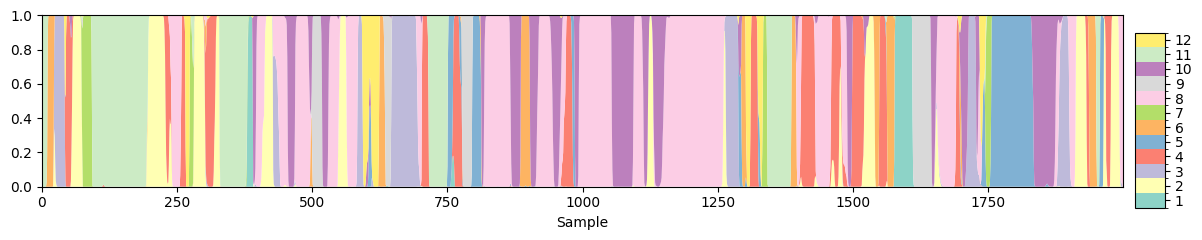

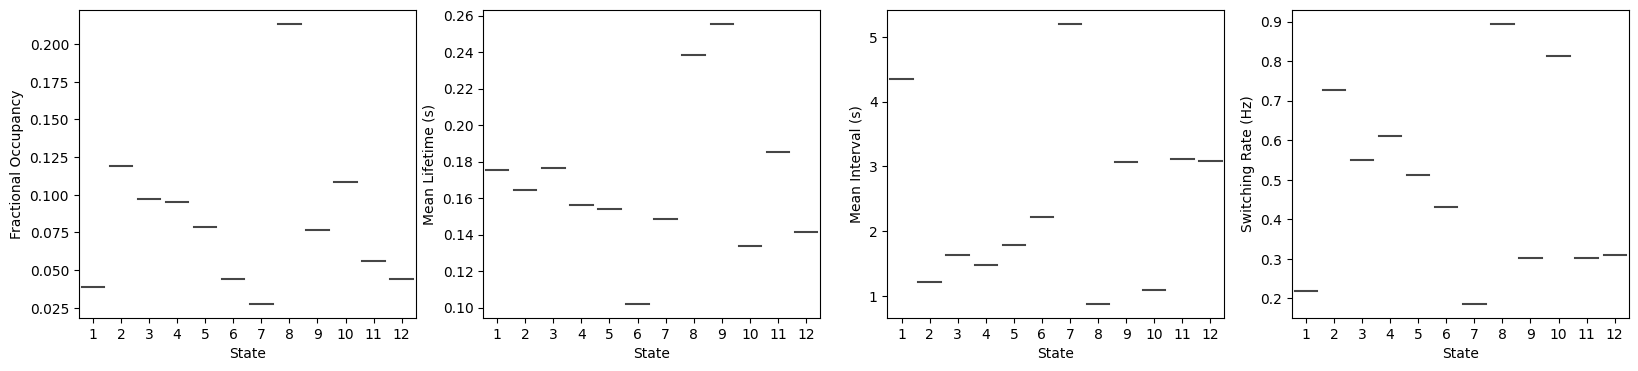

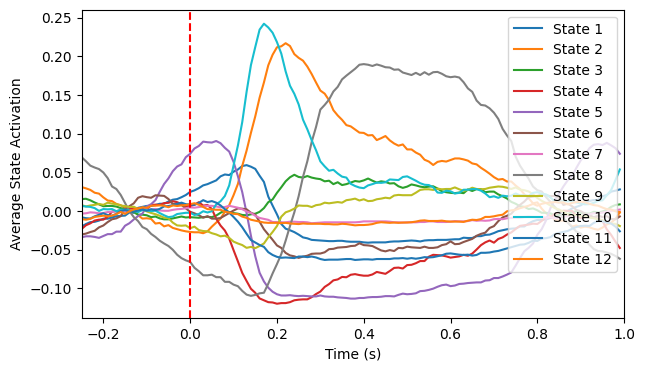

In [90]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', '100hz', '12states')
alpha, stc = plot(savedir)
evoked_analysis(savedir)

Free energy: 223123.76715213407
(358000, 12)


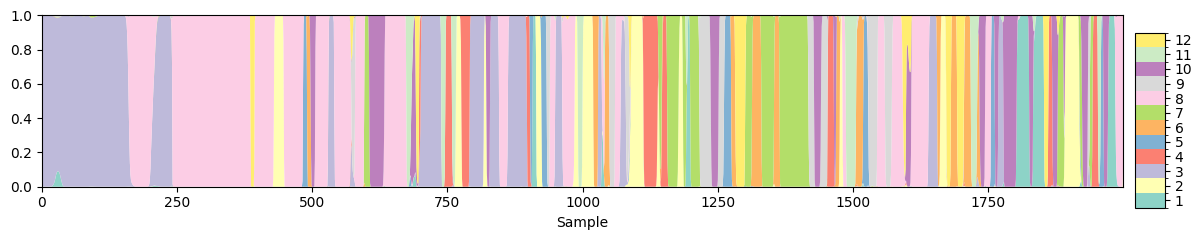

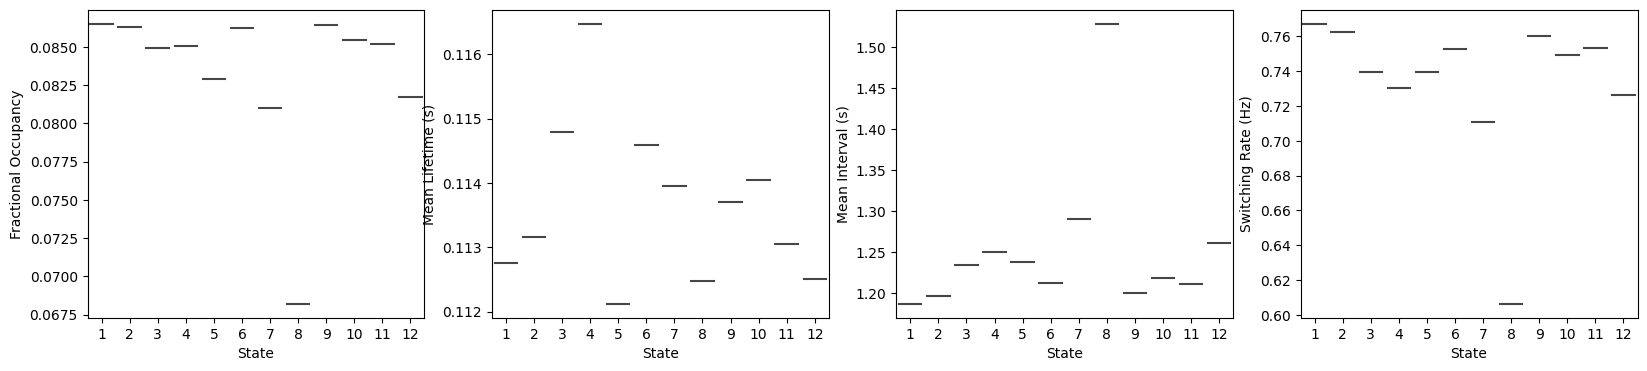

In [91]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'AR255_100hz')image.png
alpha, stc = plot(savedir)
#evoked_analysis(savedir)

Free energy: 222756.2243340329
(360000, 12)


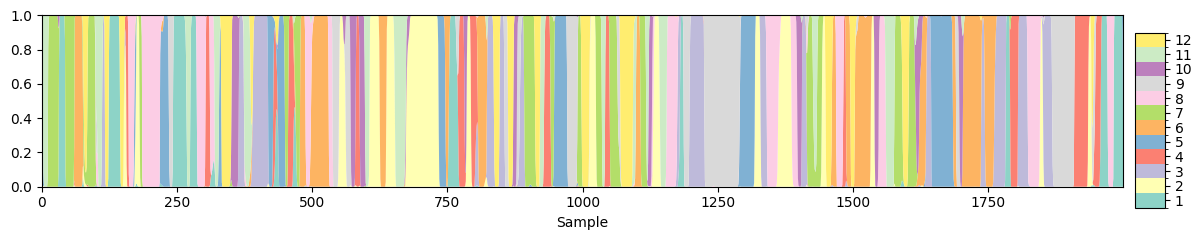

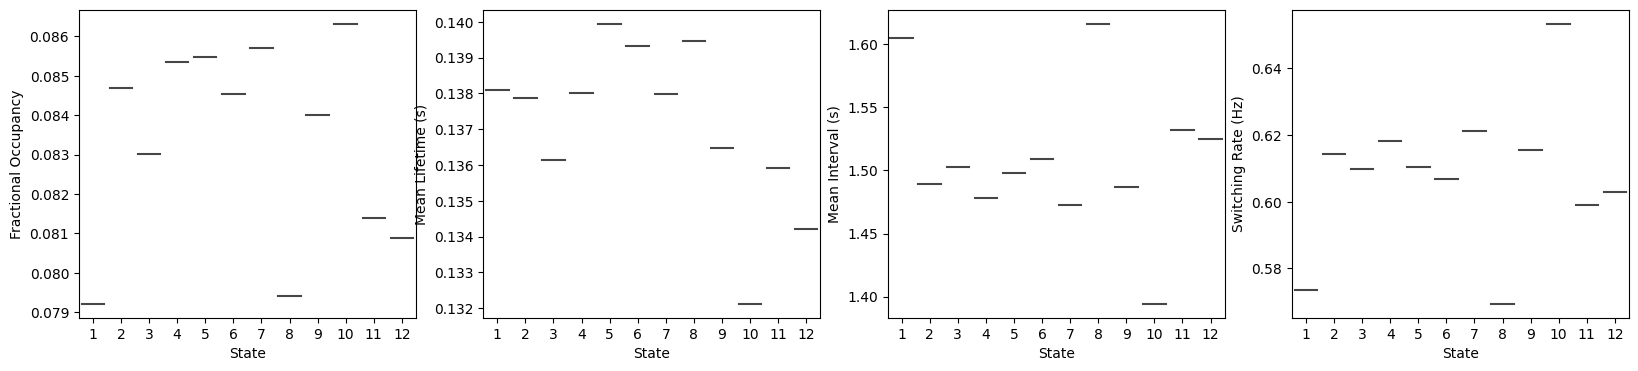

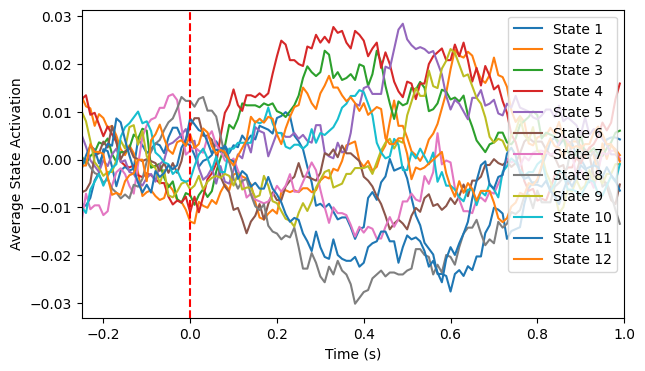

In [96]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'wavenet_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)

(100000, 12)


TypeError: evoked_analysis() got an unexpected keyword argument 'data'

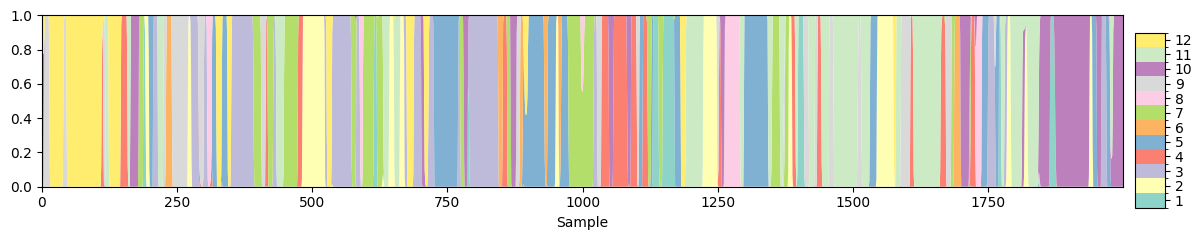

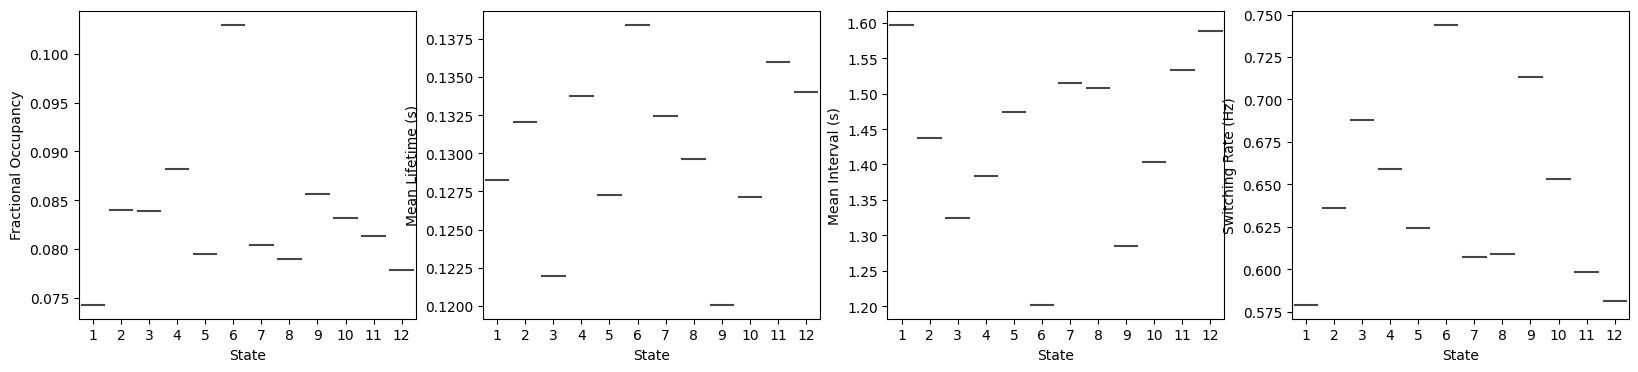

In [24]:
savedir = os.path.join('..', 'results', 'cichy_epoched', 'subj1', 'hmm', 'gpt2_100hz')
alpha, stc = plot(savedir)
evoked_analysis(savedir, data=False)